In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from vachoppy.trajectory import LatticeHopping
from vachoppy.fingerprint import FingerPrint, CosineDistance

In [6]:
class Distance_HfO2:
    def __init__(self, 
                 temp, 
                 ensemble, 
                 Rmax, 
                 delta, 
                 sigma, 
                 outdir,
                 path_poscar='./poscars_hfo2',
                 path_traj='../xdatcar.hfo2.2200K',
                 checkparam = False):
        
        self.temp = temp
        self.ensemble = ensemble
        self.Rmax = Rmax
        self.delta = delta
        self.sigma = sigma
        self.outdir = outdir
        self.path_poscar = path_poscar
        self.path_traj = path_traj
        self.checkparam = checkparam

        if not os.path.isdir(outdir):
            os.makedirs(outdir)

        self.save_fingerprint_HfO2()
        
        if not self.checkparam:
            self.get_fingerprints()
            self.plot_distance()

    def save_fingerprint_HfO2(self):
        # monoclinc
        poscar_m = os.path.join(self.path_poscar, 'POSCAR_mHfO2')
        poscar_t = os.path.join(self.path_poscar, 'POSCAR_tHfO2')
        poscar_po = os.path.join(self.path_poscar, 'POSCAR_poHfO2')
        poscar_ao = os.path.join(self.path_poscar, 'POSCAR_aoHfO2')

        # get x-coords
        fp_m_hfo = FingerPrint('Hf', 'O', poscar_m, self.Rmax, self.delta, self.sigma)
        x = fp_m_hfo.R

        # fingerprint of m-HfO2
        fp_m_hfo = fp_m_hfo.fingerprint
        fp_m_hfhf = FingerPrint('Hf', 'Hf', poscar_m, self.Rmax, self.delta, self.sigma).fingerprint
        fp_m_oo = FingerPrint('O', 'O', poscar_m, self.Rmax, self.delta, self.sigma).fingerprint
        self.fp_m = np.concatenate((fp_m_hfo, fp_m_hfhf, fp_m_oo))

        # fingerprint of t-HfO2
        fp_t_hfo = FingerPrint('Hf', 'O', poscar_t, self.Rmax, self.delta, self.sigma).fingerprint
        fp_t_hfhf = FingerPrint('Hf', 'Hf', poscar_t, self.Rmax, self.delta, self.sigma).fingerprint
        fp_t_oo = FingerPrint('O', 'O', poscar_t, self.Rmax, self.delta, self.sigma).fingerprint
        self.fp_t = np.concatenate((fp_t_hfo, fp_t_hfhf, fp_t_oo))

        # fingerprint of po-HfO2
        fp_po_hfo = FingerPrint('Hf', 'O', poscar_po, self.Rmax, self.delta, self.sigma).fingerprint
        fp_po_hfhf = FingerPrint('Hf', 'Hf', poscar_po, self.Rmax, self.delta, self.sigma).fingerprint
        fp_po_oo = FingerPrint('O', 'O', poscar_po, self.Rmax, self.delta, self.sigma).fingerprint
        self.fp_po = np.concatenate((fp_po_hfo, fp_po_hfhf, fp_po_oo))

        # fingerprint of ao-HfO2
        fp_ao_hfo = FingerPrint('Hf', 'O', poscar_ao, self.Rmax, self.delta, self.sigma).fingerprint
        fp_ao_hfhf = FingerPrint('Hf', 'Hf', poscar_ao, self.Rmax, self.delta, self.sigma).fingerprint
        fp_ao_oo = FingerPrint('O', 'O', poscar_ao, self.Rmax, self.delta, self.sigma).fingerprint
        self.fp_ao = np.concatenate((fp_ao_hfo, fp_ao_hfhf, fp_ao_oo))

        # plot fingerprints
        x_m = np.concatenate((x, x+x[-1], x+2*x[-1]))
        x_t = x_m + x_m[-1]
        x_po = x_m + x_t[-1]
        x_ao = x_m + x_po[-1]

        plt.figure(figsize=(15, 5))
        plt.plot(x_m, self.fp_m, linewidth=1.2, label='M')
        plt.plot(x_t, self.fp_t, linewidth=1.2, label='T')
        plt.plot(x_po, self.fp_po, linewidth=1.2, label='PO')
        plt.plot(x_ao, self.fp_ao, linewidth=1.2, label='AO')
        plt.axhline(0, 0, 1, color='k', linestyle='--', linewidth=1)

        plt.xlabel("r (Å)", fontsize=15)
        plt.ylabel('Intensity', fontsize=15)
        plt.legend(fontsize=15)

        outfig = os.path.join(self.outdir, "fingerprint_HfO2.png")
        plt.savefig(outfig, dpi=300)
        if self.checkparam:
            plt.show()
        plt.close()

    def get_fingerprints(self):
        
        poscar_perf = os.path.join(self.path_traj, 'POSCAR_SUPERCELL')
        xdatcar = os.path.join(self.path_traj, f"XDATCAR_{self.ensemble}")

        self.traj = LatticeHopping(poscar_perf,xdatcar,50,'O')
        self.num_step = self.traj.num_step

        for step in np.arange(self.num_step):
            self.traj.save_poscar(step=step, outdir='./poscars_traj')

        self.fp_traj = []
        for i in tqdm(range(self.num_step), desc=f"{self.ensemble}"):
            poscar = f'poscars_traj/POSCAR_{i}'
            fp_i_hfo = FingerPrint('Hf', 'O', poscar, self.Rmax, self.delta, self.sigma).fingerprint
            fp_i_hfhf = FingerPrint('Hf', 'Hf', poscar, self.Rmax, self.delta, self.sigma).fingerprint
            fp_i_oo = FingerPrint('O', 'O', poscar, self.Rmax, self.delta, self.sigma).fingerprint
            self.fp_traj.append(np.concatenate((fp_i_hfo, fp_i_hfhf, fp_i_oo)))
    
    def plot_distance(self):
        
        step = np.arange(self.num_step)

        # get cosine distance
        dist_m = np.zeros(self.num_step)
        dist_t = np.zeros(self.num_step)
        dist_po = np.zeros(self.num_step)
        dist_ao = np.zeros(self.num_step)

        for i, fp_i in enumerate(self.fp_traj):
            dist_m[i] = CosineDistance(self.fp_m, fp_i)
            dist_t[i] = CosineDistance(self.fp_t, fp_i)
            dist_po[i] = CosineDistance(self.fp_po, fp_i)
            dist_ao[i] = CosineDistance(self.fp_ao, fp_i)

        # plot cosine distance
        plt.figure(figsize=(15, 5))
        plt.scatter(step, dist_m-dist_m[0], s=25, label='M')
        plt.scatter(step, dist_t-dist_t[0], s=25, label='T')
        plt.scatter(step, dist_po-dist_po[0], s=25, label='PO')
        plt.scatter(step, dist_ao-dist_ao[0], s=25, label='AO')

        # For comparing M and T
        # step_nearest = np.argmin(dist_t-dist_m)
        # y_txt = (dist_m[step_nearest]+dist_t[step_nearest])/2

        # plt.axvline(step_nearest, 0, 1, 
        #             color='k', linestyle='--', linewidth=1)
        # plt.text(step_nearest+1, y_txt, 
        #         s=f"step {step_nearest}", fontsize=13)
        
        plt.xlabel("Step", fontsize=15)
        plt.ylabel('Cosine distnace', fontsize=15)
        plt.legend(fontsize=15, loc='center left')
        plt.title(f"{self.temp}K ({self.ensemble})", fontsize=15)

        # write info
        info = os.path.join(self.outdir, 'INFO.txt')
        with open(info, 'w') as f:
            f.write(f"data: {self.temp}K ({self.ensemble})\n")
            f.write(f"Rmax: {self.Rmax}\n")
            f.write(f"delta: {self.delta}\n")
            f.write(f"sigma: {self.sigma}\n")

        # save data
        dist_tot = np.concatenate((step, dist_m, dist_t, dist_po, dist_ao)).reshape(5,-1).T
        header = "step, M, T, PO, AO"
        outtxt = os.path.join(self.outdir, f"{self.ensemble}.txt")
        np.savetxt(outtxt, dist_tot, header=header)

        # save figures
        outfig = os.path.join(self.outdir, f"{self.ensemble}.png")
        plt.savefig(outfig, dpi=300)
        plt.close()

total:   0%|          | 0/1 [00:00<?, ?it/s]

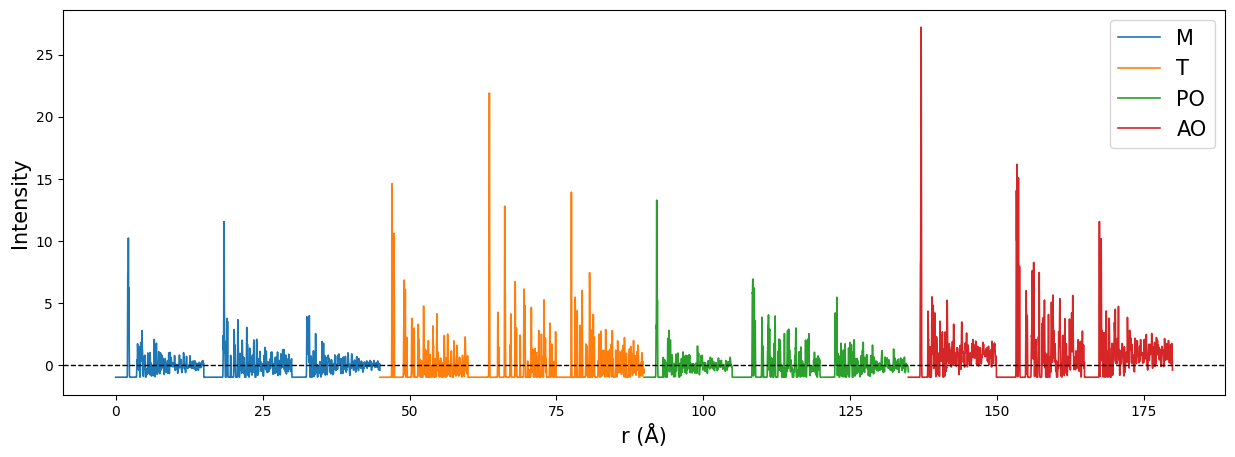

In [11]:
temp = 2200
outdir = f"{temp}K"
checkparam = True
# ensembles = [format(i+1,'02') for i in range(10)]
ensembles = ['02']

# Rmax, delta, sigma = 20, 0.004, 0.1
# Rmax, delta, sigma = 17.5, 0.007, 0.1
Rmax, delta, sigma = 15, 0.01, 0.03
# Rmax, delta, sigma = 12, 0.02, 0.1
# Rmax, delta, sigma = 10, 0.025, 0.05

for ensemble in tqdm(ensembles, desc='total'):
    _ = Distance_HfO2(temp, ensemble, Rmax, delta, sigma, outdir, checkparam=checkparam)